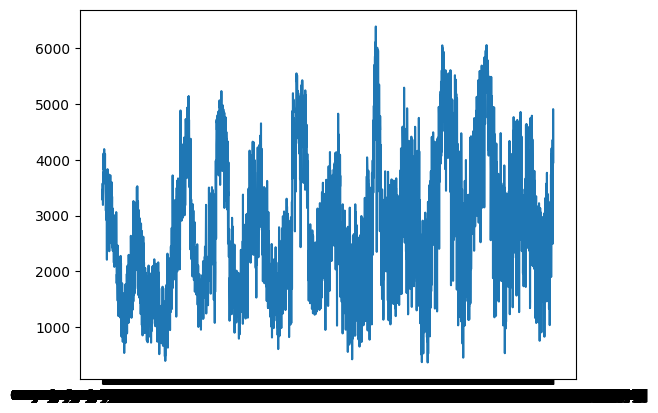

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import re

df = pd.read_csv('full_data_2011-01-01_2022-11-26.csv', sep=',')

df = df.loc[[2]].drop(columns='Unnamed: 0').T
df.columns = ['energie']
df['The_date'] = df['energie']
df.head()

dict_month = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08','Sep': '09','Oct': '10','Nov': '11','Dec': '12'}

for i in range(len(df)):
    day = "".join(re.findall("\d", df.index[i].split(" ", 1)[0]))
    month = dict_month[df.index[i].split(" ")[1]]
    year = "".join(re.findall("\d", df.index[i].split(" ", 1)[1]))
    
    the_date = f'{day}-{month}-{year}'
        
    df['The_date'].iloc[i] = the_date
    
df['The_date'] = pd.to_datetime(df['The_date'])

plt.plot(df['energie'])

In [10]:
df_rain = pd.read_csv('data_precipitation.csv', sep=';')
df_temp= pd.read_csv('temperature_data.csv', sep=';')
df_temp.drop(columns=['Unnamed: 17'], inplace = True)
df[365:]

,energie,The_date
01 Jan 12 Daily peak [MW],1530.0,2012-01-01
02 Jan 12 Daily peak [MW],1579.0,2012-02-01
03 Jan 12 Daily peak [MW],1797.0,2012-03-01
04 Jan 12 Daily peak [MW],1526.0,2012-04-01
05 Jan 12 Daily peak [MW],1237.0,2012-05-01
...,...,...
23 Nov 22 Daily peak [MW],4266.0,2022-11-23
24 Nov 22 Daily peak [MW],4731.0,2022-11-24
25 Nov 22 Daily peak [MW],4907.0,2022-11-25
26 Nov 22 Daily peak [MW],4489.0,2022-11-26


In [64]:
rem_temp = df_temp['data']
rem_rain = df_rain['data']
df_temp['data'].drop(columns='data')
df_rain['data'].drop(columns='data')

df_rain['mean'] = df_rain.mean(axis=1)
df_temp['mean'] = df_temp.mean(axis=1)

/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/ipykernel_22554/410413502.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_rain['mean'] = df_rain.mean(axis=1)
/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/ipykernel_22554/410413502.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_temp['mean'] = df_temp.mean(axis=1)


In [65]:
df = df.reset_index()

,index,Precipitation,The_date
0,01 Jan 11 Daily peak [MW],3460.0,2011-01-01
1,02 Jan 11 Daily peak [MW],3280.0,2011-02-01
2,03 Jan 11 Daily peak [MW],3577.0,2011-03-01
3,04 Jan 11 Daily peak [MW],3318.0,2011-04-01
4,05 Jan 11 Daily peak [MW],3397.0,2011-05-01
...,...,...,...
4344,23 Nov 22 Daily peak [MW],4266.0,2022-11-23
4345,24 Nov 22 Daily peak [MW],4731.0,2022-11-24
4346,25 Nov 22 Daily peak [MW],4907.0,2022-11-25
4347,26 Nov 22 Daily peak [MW],4489.0,2022-11-26


In [ ]:
for i in df.index:    
    if df['index'][i] == 09 Nov 11 Daily peak [MW]	
        print(df[i].index)

In [5]:
import pmdarima as pm

In [6]:
smodel = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=2, max_d=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, max_D=2, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=63835.002, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=63276.629, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=62645.585, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=63833.003, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=62648.892, Time=0.34 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=62646.060, Time=2.47 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=62642.322, Time=5.78 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=62643.074, Time=9.11 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=63836.213, Time=0.90 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=62512.800, Time=8.38 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=62513.248, Time=2.50 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=11.44 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=63276.277, Time=1.31 sec
 ARIMA(2,1,1)(0,

In [10]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
sarima = SARIMAX(train, order=(2, 1, 1), seasonal_order=(0, 0, 2, 12))
sarima = sarima.fit(maxiter=75)

/Users/alexander_wynaendts/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alexander_wynaendts/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82568D+00    |proj g|=  9.54367D-02

At iterate    5    f=  7.81466D+00    |proj g|=  7.91614D-03

At iterate   10    f=  7.81451D+00    |proj g|=  1.44675D-04

At iterate   15    f=  7.81450D+00    |proj g|=  2.54944D-03

At iterate   20    f=  7.81367D+00    |proj g|=  2.39405D-02

At iterate   25    f=  7.81231D+00    |proj g|=  4.02190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   

In [25]:
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

/Users/alexander_wynaendts/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [33]:
forecast

4000    3869.091791
4001    3747.634644
4002    3751.905854
4003    3708.716413
4004    3730.721395
           ...     
4344    3712.573701
4345    3712.573701
4346    3712.573701
4347    3712.573701
4348    3712.573701
Name: predicted_mean, Length: 349, dtype: float64

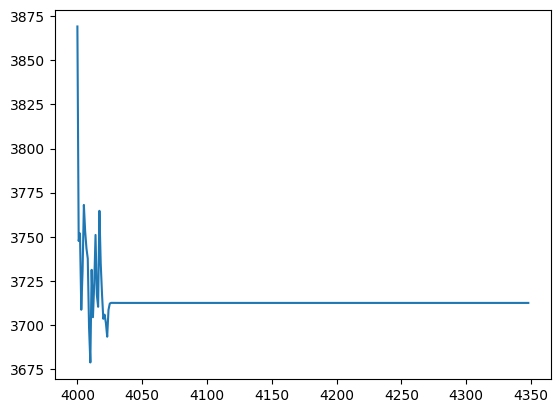

In [32]:
plt.plot(forecast)

In [28]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);


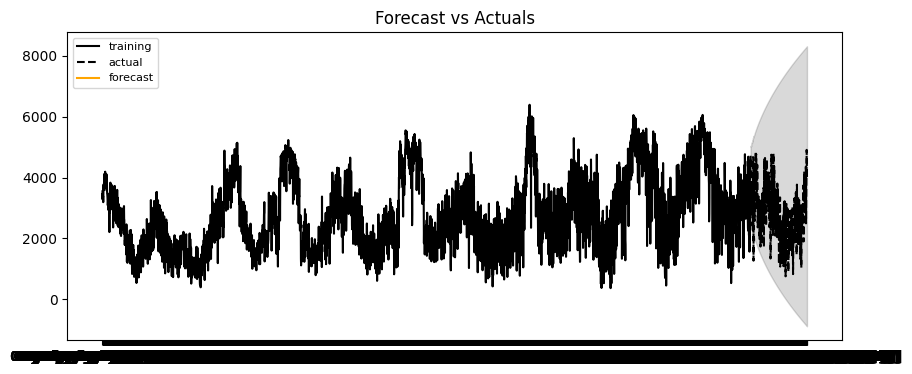

In [34]:
forecast_recons = pd.Series(forecast, index=test.index)
lower_recons = confidence_int['lower Precipitation'].values
upper_recons = confidence_int['upper Precipitation'].values

plot_forecast(forecast, train, test, upper = upper_recons, lower=lower_recons)